<a href="https://colab.research.google.com/github/IndudiniThennakoon/SE4050-DL/blob/labsheet7/lab_7_AE_CNN_Image_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [4]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1)
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[ 4.55912739e-01],
         [-3.63703787e-01],
         [-1.32974422e+00],
         ...,
         [-1.02957773e+00],
         [ 3.40139158e-02],
         [ 1.28215015e+00]],

        [[ 5.53111553e-01],
         [ 1.67569137e+00],
         [ 1.20323634e+00],
         ...,
         [ 1.19421279e+00],
         [-1.15764511e+00],
         [-1.89996064e-02]],

        [[ 1.52798116e+00],
         [-2.18880272e+00],
         [ 1.59620094e+00],
         ...,
         [ 1.36842227e+00],
         [-2.18425587e-01],
         [-2.32906437e+00]],

        ...,

        [[ 1.01323283e+00],
         [ 2.84242392e-01],
         [-1.14704204e+00],
         ...,
         [-8.99999619e-01],
         [ 1.57790577e+00],
         [ 7.65520036e-01]],

        [[-1.04272676e+00],
         [ 2.79524595e-01],
         [ 7.88599849e-01],
         ...,
         [ 5.78006841e-02],
         [ 3.26827317e-01],
         [ 2.30080318e-02]],

      

In [6]:
noise_factor = 0.2
x_train_noisy = x_train  +  noise_factor * tf.random.normal(shape=x_train.shape)
# noise factor multiplication result in increased spread in noise distribution
# result in 0.2^2 increase of variance, mean doesn't chnage (mean = 0)
x_test_noisy = x_test  +  noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [7]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

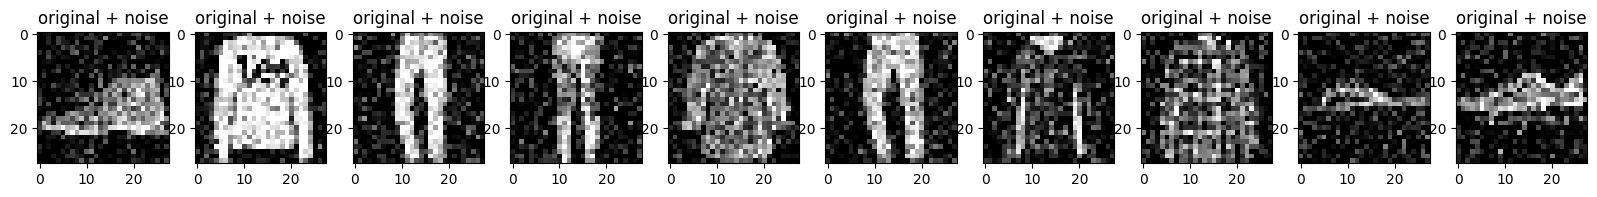

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [9]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 71s 37ms/step - loss: 0.0336 - val_loss: 0.0094
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 76s 36ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 67s 36ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - loss: 0.0070 - val_loss: 0.0070


In [13]:
autoencoder.encoder.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 8)             │           1,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
autoencoder.decoder.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose (Conv2DTranspose)   │ (32, 14, 14, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (32, 28, 28, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 28, 28, 1)             │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

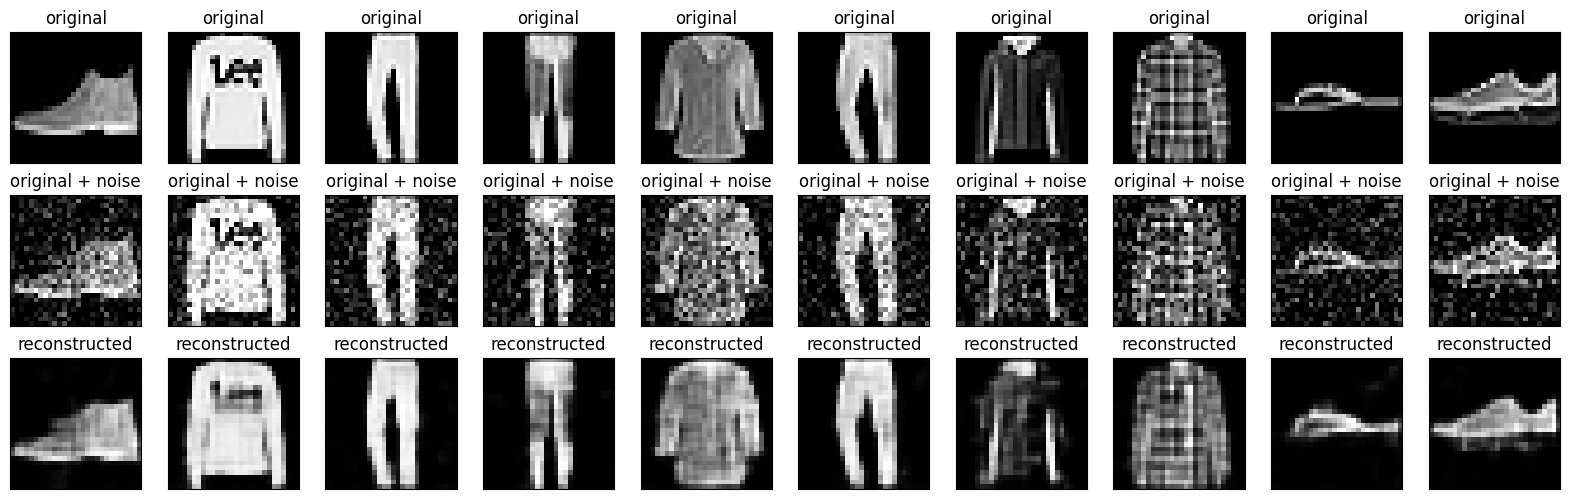

In [16]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()